In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon March 8, 2024
Author: Auro Varat Patnaik
Email: auro.patnaik@ed.ac.uk
"""

import numpy as np
import matplotlib.pyplot as plt
import lumicks.pylake as lk
import glob
import os

<div class="alert alert-block alert-danger"><b>Warning: </b>This is beta functionality. While usable, this has not yet been tested in a large number of different scenarios. The API may also still be subject to change.</div>

# Twistable Worm-Like-Chain Fitting

[Download this page as a Jupyter notebook](https://lumicks-pylake.readthedocs.io/en/stable/_downloads/501ebc5dc19f5f65b7b0dd0a3c1ff768/twlc_fitting.ipynb)

In this notebook, we analyze force extension data of DNA over its full range of structural transitions under mechanical stress (0 - 60 pN). The twistable worm-like chain model (tWLC) takes twisting deformations on the DNA double helix into account. Here we will use this model to describe the mechanical response of DNA at such high forces.

Let’s load and plot the data first:

In [2]:
dir = np.genfromtxt("input.txt",dtype='str')
default = np.genfromtxt("default.txt",dtype='str')

input_dir = dir[0,1]
output_dir = dir[1,1]
extraFilter = dir[2,1]
whichCurve = dir[3,1]
os.makedirs(output_dir, exist_ok=True)


In [3]:
fdcurves = {}
keys = []
for filename in glob.glob(input_dir+'/*.h5'):
    file = lk.File(filename)
    for key, curve in file.fdcurves.items():
        fdcurves[key] = curve
        keys.append(key)
print(fdcurves)

{'Sample1-1-10min': <lumicks.pylake.fdcurve.FdCurve object at 0x10fe0e500>, 'Sample1-1-1min': <lumicks.pylake.fdcurve.FdCurve object at 0x10fe0e650>, 'control_1': <lumicks.pylake.fdcurve.FdCurve object at 0x10fe0e710>}


In [4]:
force_distance_dict = {}
for i, curve in enumerate(fdcurves.values()):
    peak = np.argmax(curve.d.data)

    # warning if curve.d.data has negative values
    if np.min(curve.d.data) < 0:
        print("Warning: curve " + keys[i] + " has negative values of distance. Filtering the data to discount negative values. You cannot disable this.")

    # Filter the data
   
    filtered_indices = np.where((curve.d.data > 1e-6)) # filter out negative values


    # comment either of them to get only extension or retraction
    if whichCurve == "extension":
        force_extension = curve.f.data[filtered_indices][:peak]
        distance_extension = curve.d.data[filtered_indices][:peak]
        force_distance_dict[keys[i]] = [force_extension, distance_extension]
    elif whichCurve == "retraction":
        force_retraction = curve.f.data[filtered_indices][peak:]
        distance_retraction = curve.d.data[filtered_indices][peak:]
        force_distance_dict[keys[i]] = [force_retraction, distance_retraction]
    else:
        force_extension = curve.f.data[filtered_indices][:peak]
        distance_extension = curve.d.data[filtered_indices][:peak]
        force_retraction = curve.f.data[filtered_indices][peak:]
        distance_retraction = curve.d.data[filtered_indices][peak:]
        force_distance_dict[keys[i]+"_extension"] = [force_extension, distance_extension]
        force_distance_dict[keys[i]+"_retraction"] = [force_retraction, distance_retraction]

In [5]:
sample_name = list(force_distance_dict.keys())

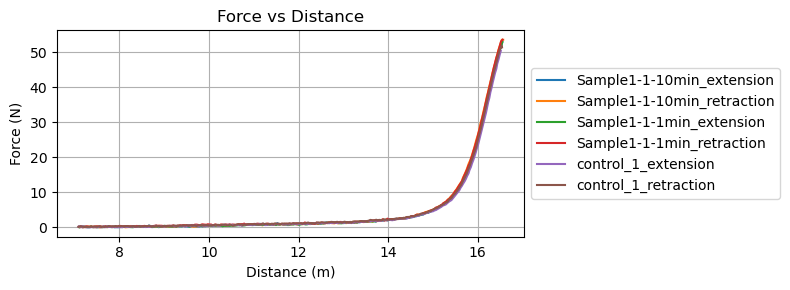

In [6]:
# using force_distance_dict to plot the fd curves with small plots for each curve
fig, ax = plt.subplots()
# small size
fig.set_size_inches(8, 3)
for key, value in force_distance_dict.items():
    ax.plot(value[1], value[0], label=key)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Force (N)')
    ax.legend()
    ax.set_title('Force vs Distance')
    ax.grid(True)
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Set up a basic model first

We clearly see that the force starts levelling out at high forces in the data. We’ll need something rather complex in order to capture this behavior. The twistable worm-like chain (tWLC) model can describe the untwisting behavior of DNA that becomes apparent in the 30-60 pN force range. However, the model’s complexity also incurs some challenges.

Parameter estimation typically begins from an initial guess, and if this initial guess is bad, it can get stuck at an estimated set of parameters that are suboptimal, a so-called local optimum. One way to mitigate this, is to start with better initial values.

In this notebook, we fit the region before the force begins levelling out (i.e. 30 pN) first with a regular worm-like chain model and then use those estimates as initial guesses to fit the tWLC model.

Depending on your experiments, small offsets can be present in the data. For instance, the bead diameter may vary slightly from experiment to experiment, or the force may have experienced some drift. We incorporate an offset in both distance and force to compensate for small offsets that may exist in the data. Let’s set up the Odijk worm-like chain model and create the fit:

In [7]:
m_odijk = lk.ewlc_odijk_force("DNA").subtract_independent_offset() + lk.force_offset("DNA")
m_dna = lk.twlc_force("DNA").subtract_independent_offset() + lk.force_offset("DNA")


In [8]:
def set_params(fit, limit=None):
    for i in default[slice(*limit)]:
        setattr(fit[i[0]], i[2], float(i[1]))
    return fit

In [9]:
# Multiple Independent Fits
def independent_fits(force_distance_dict,model,initial_guess_dict=False,param_limit=None):
    fits = {}
    
    for i, (force_array,distance_array) in enumerate(force_distance_dict.values()):
        # Add a dataset to the fit
       
        fit = lk.FdFit(model)
      
        if initial_guess_dict == False:
            # This means we are fitting the Odijk model, so we filter data to get forces < 30
            mask = force_array < 30
            force_array = force_array[mask]
            distance_array = distance_array[mask]

        fit.add_data(sample_name[i], force_array, distance_array) 
            
        if initial_guess_dict:
            fit.update_params(initial_guess_dict[sample_name[i]])

        fit = set_params(fit,param_limit)
        fit.fit()

        fits[sample_name[i]] = fit
    
    
    return fits



In [10]:
f_guess = independent_fits(force_distance_dict,m_odijk,initial_guess_dict=False,param_limit=(0,2))
final_fit = independent_fits(force_distance_dict,m_odijk,initial_guess_dict=f_guess,param_limit=(2,))

In [11]:
# Save the values of all params for each curve
values = []
for i in sample_name:
    values.append([i]+[final_fit[i].params[j].value for j in final_fit[i].params.keys()])
np.savetxt(output_dir+'/values.txt',values,fmt='%s',header='Sample Name,'+','.join(list(final_fit[sample_name[0]].params.keys())),delimiter=',')


In [12]:
"""
Save the force distance arrays to a file of sample name 
"""
for i, (force_array,distance_array) in enumerate(force_distance_dict.values()):
    np.savetxt(output_dir+'/'+sample_name[i]+'.txt',np.array([force_array,distance_array]).T,fmt='%s',header='Force,Distance',delimiter=',')


In [13]:
final_fit[sample_name[0]].params

Name,Value,Unit,Fitted,Lower bound,Upper bound
DNA/d_offset,0.00930946,[micron],True,-0.01,0.01
DNA/Lp,30.8522,[nm],True,0.001,100
DNA/Lc,16.3,[micron],True,0.00034,inf
DNA/St,1396.89,[pN],True,1,inf
kT,4.11,[pN*nm],False,3.77,8
DNA/f_offset,0.1,[pN],True,-0.1,0.1


<h1>Visualisation</h1>

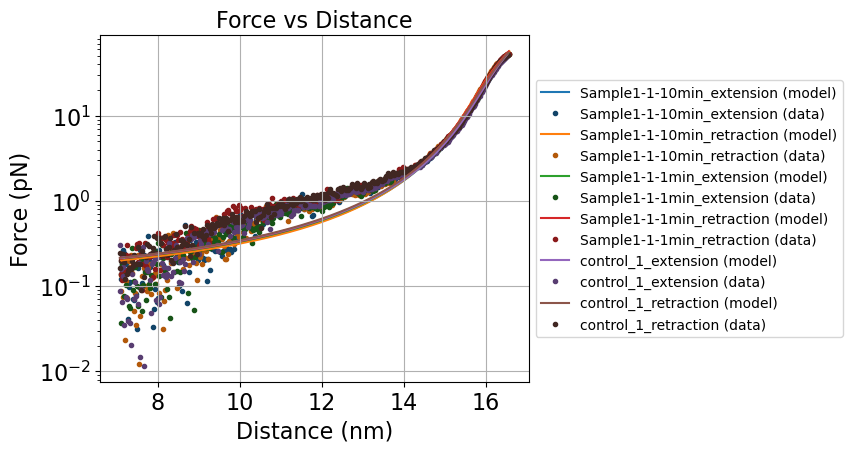

In [14]:
# plot all the fits
fig, ax = plt.subplots()
# small size
fig.set_size_inches(8, 4)
for i in sample_name:
    final_fit[i].plot()
 # put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# font size of x and y axis
plt.title('Force vs Distance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# label size of x and y axis
plt.xlabel('Distance (nm)',fontsize=16)
plt.ylabel('Force (pN)',fontsize=16)
# make x,y log
# add grid
plt.grid(True)

plt.yscale('log')
plt.savefig(output_dir+'/fit.png')
plt.show()


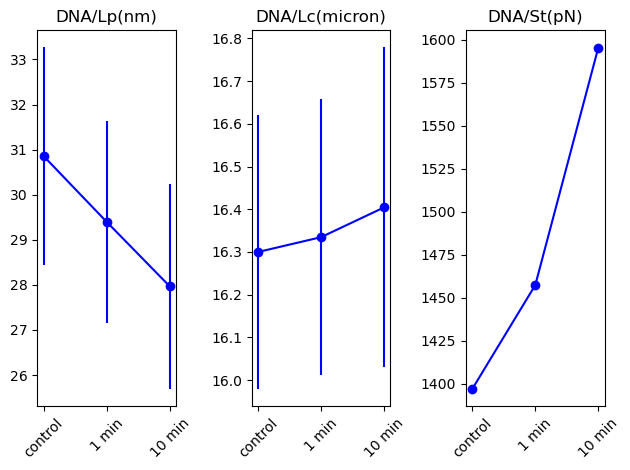

In [15]:
"""
In a plot, plot the DNA/Lp values for each curve with extension and retraction in different colors
"""
#  put all DNA/Lp  for extension and retraction in separate lists
extension_name = ["control","1 min","10 min"]
extension = []
extension_error = []
retraction_name= []
retraction = []
for i in sample_name:
    if "extension" in i:
        # extension_name.append(i)
        extension.append([final_fit[i]['DNA/Lp'].value,final_fit[i]['DNA/Lc'].value,final_fit[i]['DNA/St'].value])
        extension_error.append([final_fit[i]['DNA/Lp'].stderr,final_fit[i]['DNA/Lc'].stderr,final_fit[i]['DNA/St'].stderr])
    # else:
    #     retraction_name.append(i)
    #     retraction.append([final_fit[i]['DNA/Lp'].value,final_fit[i]['DNA/Lc'].value,final_fit[i]['DNA/St'].value])

plt.figure()
# small size

# add space between the plots
# DNA/Lp plot
plt.subplot(1, 3, 1)
# plot it with line and error bars
plt.errorbar(extension_name,np.array(extension)[:,0],yerr=np.array(extension_error)[:,0],fmt='o-',label="Extension", color='blue')
plt.xticks(rotation=45)
plt.title('DNA/Lp(nm)')
# remove legend from the plot

# DNA/Lc plot
plt.subplot(1, 3, 2)
# plot it with line and error bars
plt.errorbar(extension_name,np.array(extension)[:,1],yerr=np.array(extension_error)[:,1],fmt='o-',label="Extension", color='blue')

plt.xticks(rotation=45)
plt.title('DNA/Lc(micron)')
# remove legend from the plot

# DNA/St plot
plt.subplot(1, 3, 3)

# plot it with line and error bars
plt.errorbar(extension_name,np.array(extension)[:,2],yerr=np.array(extension_error)[:,2],fmt='o-',label="Extension", color='blue')
plt.title('DNA/St(pN)')

plt.xticks(rotation=45)

plt.tight_layout()

# Increase horizontal spacing between subplots

plt.savefig(output_dir+'/DNA_Lp_Lc_St.png')
plt.show()


<!-- add heading -->
<h1>Archival</h1>

In [16]:
# Single Global Fit
def global_fit(force_distance_dict):
    # Create a new model
    
    fit = lk.FdFit(model)

    sample_name = list(force_distance_dict.keys())
    
    for i, (force_array,distance_array) in enumerate(force_distance_dict.values()):
        # stop it after two datasets
    
        # Add a dataset to the fit
        fit.add_data(sample_name[i], force_array, distance_array)
        fit = set_params(fit)
  
    fit.fit()

    return fit